<a href="https://colab.research.google.com/github/cagBRT/Data/blob/main/5b_Outliers_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/are-outliers-harder-to-predict-ae84dd4be465

In this notebook we work with outliers.  <br>
We try to answer the question, what should we do with outliers?.

## Do ML models make more mistakes with outliers?

Outliers are usually viewed with suspicion and are often removed. <br>

But Is this the best practice?


Outliers are individuals that are very different from the majority of the population. Traditionally, among practitioners there is a certain mistrust in outliers, this is why ad-hoc measures such as removing them from the dataset are often adopted.

Sometimes, outliers are even more important than other observations. <br>

For example, the case of individuals that are outliers because they are very high-paying customers: you don’t want to discard them, if fact, you probably want to treat them with extra care.



In this notebook we try to answer the question: <br>

**Is an ML model more likely to make mistakes when making predictions on outliers?**

To sum up, we may imagine three possibilities:

outliers are harder to predict<br>
outliers are easier to predict<br>
outliers are neither harder nor easier to predict<br>


In [157]:
!pip install pycaret --quiet

In [158]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import IsolationForest
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [200]:
DATASET_NAMES = [ "bank", "bike", "cancer", "credit", "diabetes", "electrical_grid",
                 "employee", "heart", "heart_disease", "hepatitis", "income", "juice",
                 "nba", "wine", "telescope", "titanic", "us_presidential_election_results"]

In [198]:
all_datasets = get_data('index')

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,NaN,NaN,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,NaN,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,NaN,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,NaN,683,10,N
6,credit,Multivariate,Classification (Binary),default,NaN,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,NaN,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,NaN,10000,14,N
9,employee,Multivariate,Classification (Binary),left,NaN,14999,10,N


**Define functions for use in this notebook**

In [160]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def individual_log_loss(y_true, y_pred, eps=1e-15):
  """Compute log-loss for each individual of the sample."""
  y_pred = np.clip(y_pred, eps, 1 - eps)
  return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

## Case 1

Let's look at a case where a model has been trained on the dataset shown below.

**Plot the synthetic data**

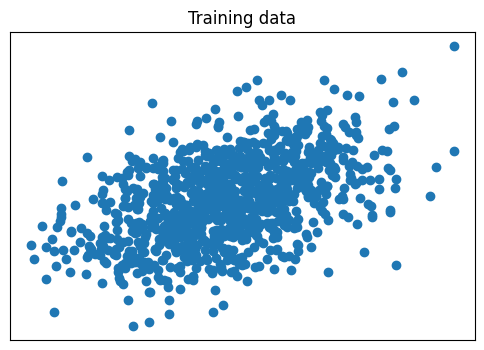

In [161]:
fig, ax = plt.subplots(figsize=(6,4))
x = np.random.multivariate_normal([0,0], [[1,.6],[.6,2]], size=1000)
ax.scatter(x[:,0], x[:,1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Training data")
fig.savefig(f"example_training.png", dpi=200, bbox_inches="tight")

**If new data is collected it can be**:
1. an outlier
2. falls within the standard range for data

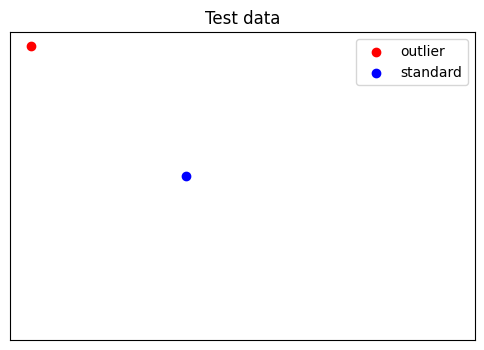

In [162]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x[:,0], x[:,1], color="white")
ax.scatter(np.min(x, axis=0)[0], np.max(x, axis=0)[1], color="red", label="outlier")
ax.scatter(np.quantile(x, q=.3, axis=0)[0], np.quantile(x, q=.7, axis=0)[1], color="blue", label="standard")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Test data")
ax.legend(loc="upper right")
fig.savefig(f"example_test.png", dpi=200, bbox_inches="tight")

**Question for discussion:** <br>
Is the outlier going to harder to predict than the standard data point?<br>



Three possible outcomes: <br>
1. outliers are harder to predict
2. outiers are easier to predict
3. outliers are neither harder or easier to predict

## Experiment 1

We use a bank customer datset. <br>

"bank": https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification




**Get the bank dataset**<br>
The dataset contains:<br>

Personal information: <br>
- age, job, education level, and marital status<br>

account information: <br>
- balance, credit status,housing loan status, personal loan status<br>

marketing information: <br>
- contact method, day of week of last contact, month of last contact, length of last contact, number of contacts, number of contacts, outcome of last campaign<br>

Label: <br>
- the label will predict if the customer will purchase a bank term deposit (Yes=1, No=0)<br>

In [163]:
datasets = get_data(verbose=False)

"bank": https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification<br>

"telescope": https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

**Prepare the dataset and split into training and test sets**

In [164]:
dataset_name = "bank"
X, y, num_features, cat_features = get_dataset(dataset_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Training set:",X_train.shape, y_train.shape)
print("Test set:",X_test.shape, y_test.shape)

Training set: (33908, 16) (33908,)
Test set: (11303, 16) (11303,)


**All the inputs to the model**

In [165]:
print("All features: ",X_train.columns)
print("Numerical features: ",num_features)

All features:  Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
Numerical features:  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']




---



---



---



## Categorical Encoding with CatBoost Encoder<br>

We must convert the categorical data to numeric data. There are a number of categircial encoding methods we can use. <br>

In this case we care going to use Catboost. <br>

CatBooset encoding is used for categorical features.
There are various categorical encoding methods available. Catboost is one of them.<br>

Catboost is a target-based categorical encoder. It is a supervised encoder that encodes categorical columns according to the target value. It supports binomial and continuous targets.<br>
[Catboost is a target-based categorical encoder](https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/).  It encodes according to a target value and supports binomial and continuous targets. <br>

Target encoding replaces the categorical values with the average value for each column. This can introduce data leakage since the target is used to predict the target. <br>

Catboost solves the data leakage issue by using an ordering principle.



**A quick example of CatBootEncoder**

In [166]:
# Make dataset
train = pd.DataFrame({
    'color': ["red", "blue", "blue", "green", "red",
              "red", "black", "black", "blue", "green"],

    'interests': ["sketching", "painting", "instruments",
                  "sketching", "painting", "video games",
                  "painting", "instruments", "sketching",
                  "sketching"],

    'height': [68, 64, 87, 45, 54, 64, 67, 98, 90, 87],

    'grade': [1, 2, 3, 2, 3, 1, 4, 4, 2, 3], })

# Define train and target
target = train[['grade']]
train = train.drop('grade', axis = 1)

# Define catboost encoder
cbe_encoder = CatBoostEncoder()

# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

# We can use fit_transform() instead of fit()
# and transform() separately as follows:
# train_cbe = cbe_encoder.fit_transform(train,target)
train_cbe

,color,interests,height
0,1.875,2.100000,68
1,2.375,2.875000,64
2,2.375,3.166667,87
3,2.500,2.100000,45
4,1.875,2.875000,54
5,1.875,2.500000,64
6,3.500,2.875000,67
7,3.500,3.166667,98
8,2.375,2.100000,90
9,2.500,2.100000,87




---

**End of CatBoostEncoder Example**

---



## Use CatBoostEncoder on our dataset

In [167]:
cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
cat_encoder

CatBoostEncoder(cols=['job', 'marital', 'education', 'default', 'housing',
                      'loan', 'contact', 'month', 'poutcome'])

**The data before CatBoost**

In [168]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
18248,34,admin.,married,secondary,no,244,yes,no,cellular,31,jul,56,4,-1,0,unknown
27333,40,blue-collar,married,primary,no,-616,yes,no,cellular,21,nov,182,1,157,2,failure
40838,81,retired,married,primary,no,0,no,no,telephone,11,aug,198,1,-1,0,unknown
42182,27,services,single,secondary,no,6279,yes,no,cellular,9,nov,257,1,-1,0,unknown
788,29,student,single,tertiary,no,185,yes,no,unknown,7,may,141,3,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41837,74,retired,married,primary,no,279,no,no,telephone,15,oct,227,1,-1,0,unknown
15814,42,technician,married,secondary,yes,55,yes,no,cellular,21,jul,291,1,-1,0,unknown
25989,53,blue-collar,single,secondary,no,2430,yes,yes,cellular,19,nov,73,2,145,3,failure
8735,44,blue-collar,married,primary,no,924,yes,no,unknown,4,jun,89,3,-1,0,unknown


In [169]:
X_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [170]:
if len(cat_features) > 0:
  #fill empty values with NULL
    cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
  #transform the categorical data to numerical data
    X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
    X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
  #fill any missing data with the mean of the dataset
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())

In [171]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
18248,34,0.118908,0.101447,0.106435,0.118986,244,0.078327,0.127738,0.150460,31,0.091652,56,4,-1,0,0.092142
27333,40,0.073344,0.101447,0.088230,0.118986,-616,0.078327,0.127738,0.150460,21,0.104213,182,1,157,2,0.128852
40838,81,0.231550,0.101447,0.088230,0.118986,0,0.167368,0.127738,0.133724,11,0.110452,198,1,-1,0,0.092142
42182,27,0.088283,0.151496,0.106435,0.118986,6279,0.078327,0.127738,0.150460,9,0.104213,257,1,-1,0,0.092142
788,29,0.301323,0.151496,0.151961,0.118986,185,0.078327,0.127738,0.041636,7,0.068043,141,3,-1,0,0.092142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41837,74,0.231550,0.101447,0.088230,0.118986,279,0.167368,0.127738,0.133724,15,0.452046,227,1,-1,0,0.092142
15814,42,0.113880,0.101447,0.106435,0.068933,55,0.078327,0.127738,0.150460,21,0.091652,291,1,-1,0,0.092142
25989,53,0.073344,0.151496,0.106435,0.118986,2430,0.078327,0.067437,0.150460,19,0.104213,73,2,145,3,0.128852
8735,44,0.073344,0.101447,0.088230,0.118986,924,0.078327,0.127738,0.041636,4,0.103877,89,3,-1,0,0.092142


In [172]:
#X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
#X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
#X_train = X_train.fillna(X_train.mean())
#X_test = X_test.fillna(X_train.mean())

In [173]:
print("training dataset shape:",X_train.shape)
print("test dataset shape:",X_test.shape)

training dataset shape: (33908, 16)
test dataset shape: (11303, 16)


## Isolation Foreset

An Isolation Forest is an unsupervised model which can output a score of outlierness for each individual of your dataset.

It returns the anomaly score of each sample using the IsolationForest algorithm



**Identify outliers in the dataset**

In [174]:
#The number of base estimators in the ensemble = 100
iforest = IsolationForest(n_estimators = 100).fit(X_train)
iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
print("Anomoly scores for the labels in the test set:\n",iforest_scores_test)

Anomoly scores for the labels in the test set:
 40594    0.470882
25619    0.435708
15645    0.408242
17788    0.437595
5889     0.419331
           ...   
31187    0.468023
27237    0.378147
11858    0.405571
45062    0.552060
21281    0.380044
Length: 11303, dtype: float64


In [175]:
#iforest = IsolationForest(n_estimators = 100).fit(X_train)
#iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)

## LGB Classifier (Light Gradient Boosting Model)

LGB uses decision tree algorithms for ranking, classification, and other machine-learning tasks

In [176]:
model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10018
           1       0.64      0.49      0.55      1285

    accuracy                           0.91     11303
   macro avg       0.79      0.73      0.75     11303
weighted avg       0.90      0.91      0.91     11303



## Log_loss

Log-loss is one of the major metrics to assess the performance of a classification problem.<br>

>"Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value."



**What is log-loss?**<br>

A binary classification algorithm first predicts probability of a record to be classified under class 1 and then classifies the data point (record) under one of the two classes (1 or 0) based on whether the probability crossed a threshold value, which is usually set at 0.5 by default.<br>

![picture](https://github.com/cagBRT/Data/blob/main/images/logLoss.png?raw=1)<br>

Before predicting the class of the record, the model has to predict the probability of the record to be classified under class 1. Remember that it is this prediction probability of a data record that the log-loss value is dependent on.

In [177]:
logloss_test = individual_log_loss(y_test, pred_test)
print(logloss_test)
#Each label with the probability of the record being classified as class 1

40594    1.464224
25619    0.585758
15645    0.108822
17788    0.022465
5889     0.002416
           ...   
31187    1.672965
27237    0.229957
11858    0.000613
45062    0.006623
21281    0.005046
Length: 11303, dtype: float64


**Find the highest anomaly score**
1. Take the anomoly scores and sort them in asending order
2. id will equal the highest anomoly score

In [178]:
id = iforest_scores_test.sort_values().tail(1).index[0]
print("the highest iforest score belongs to customer: ",id)

the highest iforest score belongs to customer:  44738


In [179]:
x = X_train.apply(lambda col: percentileofscore(col, X_test.loc[id, col.name])
).sort_values(key=lambda x: np.abs(50-x), ascending=False).rename("quantile") / 100

In [180]:
pd.concat([iforest_scores_test.rename("outlierness_test"), logloss_test.rename("logloss_test")], axis=1).head()

,outlierness_test,logloss_test
40594,0.470882,1.464224
25619,0.435708,0.585758
15645,0.408242,0.108822
17788,0.437595,0.022465
5889,0.419331,0.002416


In [181]:
print("Column name   score")
print(x)

Column name   score
age          0.997464
previous     0.996299
poutcome     0.982865
month        0.978530
balance      0.974564
job          0.954111
duration     0.917350
pdays        0.835614
housing      0.776764
day          0.233912
campaign     0.725286
marital      0.299738
contact      0.319733
education    0.408222
loan         0.580055
default      0.509010
Name: quantile, dtype: float64


**List the outliers**

In [182]:
out = pd.concat([
    X.loc[id, x.index].rename("original data"), x ], axis=1).round(2)
out

,original data,quantile
age,80,1.00
previous,13,1.00
poutcome,success,0.98
month,sep,0.98
balance,8304,0.97
job,retired,0.95
duration,606,0.92
pdays,91,0.84
housing,no,0.78
day,8,0.23


In [183]:
outliers=out[(out["quantile"] > .95) | (out["quantile"] < .05)]
outliers

,original data,quantile
age,80,1.00
previous,13,1.00
poutcome,success,0.98
month,sep,0.98
balance,8304,0.97


In [184]:
#The max iforest_scores_test
print("this is the max outlierness scoure: ",iforest_scores_test.max())

this is the max outlierness scoure:  0.6836583643783798


In [185]:
final=pd.concat([iforest_scores_test.rename("outlierness_test"),
           logloss_test.rename("logloss_test")], axis=1)
final

,outlierness_test,logloss_test
40594,0.470882,1.464224
25619,0.435708,0.585758
15645,0.408242,0.108822
17788,0.437595,0.022465
5889,0.419331,0.002416
...,...,...
31187,0.468023,1.672965
27237,0.378147,0.229957
11858,0.405571,0.000613
45062,0.552060,0.006623


**Get the most extreme outlier**

In [186]:
#Get information about the customer with the highest outlierness
final.loc[final["outlierness_test"].idxmax()]


outlierness_test    0.683658
logloss_test        0.242425
Name: 44738, dtype: float64

In [187]:
print(X.loc[[43342]])

       age         job marital education default  balance housing loan  \
43342   27  management  single  tertiary      no     6791      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  
43342  telephone   22   mar       174         2    229        28  success  


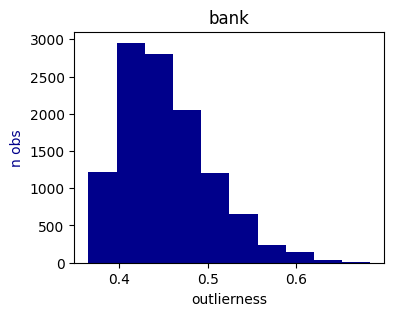

In [188]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.hist(iforest_scores_test, color="darkblue")
ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
fig.savefig(f"{dataset_name}_hist.png", dpi=200, bbox_inches="tight")

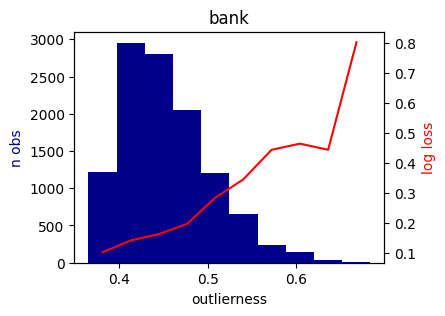

In [189]:
cut=pd.cut(iforest_scores_test, bins=10)
logloss = logloss_test.groupby(cut).mean()
fig, ax1 = plt.subplots(figsize=(4,3))
ax2 = ax1.twinx()
ax1.hist(iforest_scores_test, color="darkblue")
ax2.plot([i.mid for i in logloss.index], logloss, color="red")
ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
ax2.set_ylabel("log loss", color="red")
fig.savefig(f"{dataset_name}_hist_logloss.png", dpi=200, bbox_inches="tight")

**Repeat for different datasets**

In [190]:
dataset_names = []
for dataset_name in DATASET_NAMES:
  X, y, num_features, cat_features = get_dataset(dataset_name)
  if len(X) > 5000: dataset_names.append(dataset_name)

**tqdm:** makes your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!

In [201]:
results = []
for dataset_name in tqdm(dataset_names):
  X, y, num_features, cat_features = get_dataset(dataset_name)
  print(dataset_name)
  for iteration in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    if len(cat_features) > 0:
       cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
       X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
       X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
       X_train = X_train.fillna(X_train.mean())
       X_test = X_test.fillna(X_train.mean())
       iforest = IsolationForest(n_estimators = 100).fit(X_train)
       iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
       model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
       pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
       logloss_test = individual_log_loss(y_test, pred_test)
       iforest_q95 = iforest_scores_test.quantile(.95)
       outliers_vs_rest = (iforest_scores_test > iforest_q95).replace({True: "outliers", False: "rest"})
       logloss = logloss_test.groupby(outliers_vs_rest).mean()
       results.append({ "dataset name": dataset_name, "iteration": iteration, "n outliers":
        (iforest_scores_test > iforest_q95).sum(), "log-loss": logloss.mean(), "log-loss (outliers)": logloss["outliers"], "log-loss (rest)": logloss["rest"] })

  0%|          | 0/7 [00:00<?, ?it/s]

bank


 29%|██▊       | 2/7 [00:12<00:25,  5.18s/it]

credit


 43%|████▎     | 3/7 [00:13<00:13,  3.41s/it]

electrical_grid
employee


 57%|█████▋    | 4/7 [00:16<00:10,  3.37s/it]

income


 86%|████████▌ | 6/7 [00:25<00:03,  3.65s/it]

wine


100%|██████████| 7/7 [00:26<00:00,  3.82s/it]

telescope


In [202]:
results_agg = pd.DataFrame(results).groupby("dataset name").agg({ "dataset name": lambda x: x.values[0], "iteration": lambda x: len(x), "n outliers": np.min, "log-loss": np.mean, "log-loss (outliers)": np.mean, "log-loss (rest)": np.mean, })
results_agg["ratio"] = np.maximum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"]) / np.minimum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"])
results_agg = results_agg.sort_values("ratio", ascending=False)
results_agg

,dataset name,iteration,n outliers,log-loss,log-loss (outliers),log-loss (rest),ratio
dataset name,,,,,,,
bank,bank,5,566,0.317392,0.450899,0.183885,2.452077
employee,employee,5,188,0.035370,0.024805,0.045935,1.851838
income,income,5,407,0.258934,0.232513,0.285355,1.227265


In [195]:
results_agg.loc[:,["log-loss","log-loss (outliers)","log-loss (rest)"]].round(3).style.apply(lambda x: ["background: red" if (v > results_agg["log-loss"].iloc[e] and x.name =="log-loss (outliers)") else ("background: lightgreen"
                                                                                                                                                                                                               if x.name=="log-loss (outliers)" else "") for e, v in enumerate(x)])

,log-loss,log-loss (outliers),log-loss (rest)
dataset name,,,
bank,0.314000,0.446000,0.183000
income,0.248000,0.213000,0.284000
employee,0.048000,0.046000,0.051000
